In [1]:
# from zipfile import ZipFile
# with ZipFile('MWD.zip', 'r') as zipObj:

#     zipObj.extractall('MWD')

In [2]:
# pip install split-folders[full]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import splitfolders

input_folder = 'MWD/Multi-class Weather Dataset'
splitfolders.ratio(input_folder, output="dataset", seed=337, ratio=(0.7, 0.3), group_prefix=None)


Copying files: 1125 files [00:02, 546.85 files/s]


In [6]:
import os
import cv2
import numpy as np
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity


Class: Cloudy
Precision: 81.25%
Recall: 91.08%
F1 Score: 85.89%

Class: Rain
Precision: 85.29%
Recall: 83.65%
F1 Score: 84.47%

Class: Shine
Precision: 91.67%
Recall: 80.49%
F1 Score: 85.71%

Class: Sunrise
Precision: 90.45%
Recall: 89.44%
F1 Score: 89.94%

Overall Results:
Precision: 87.20%
Recall: 86.88%
F1 Score: 86.88%


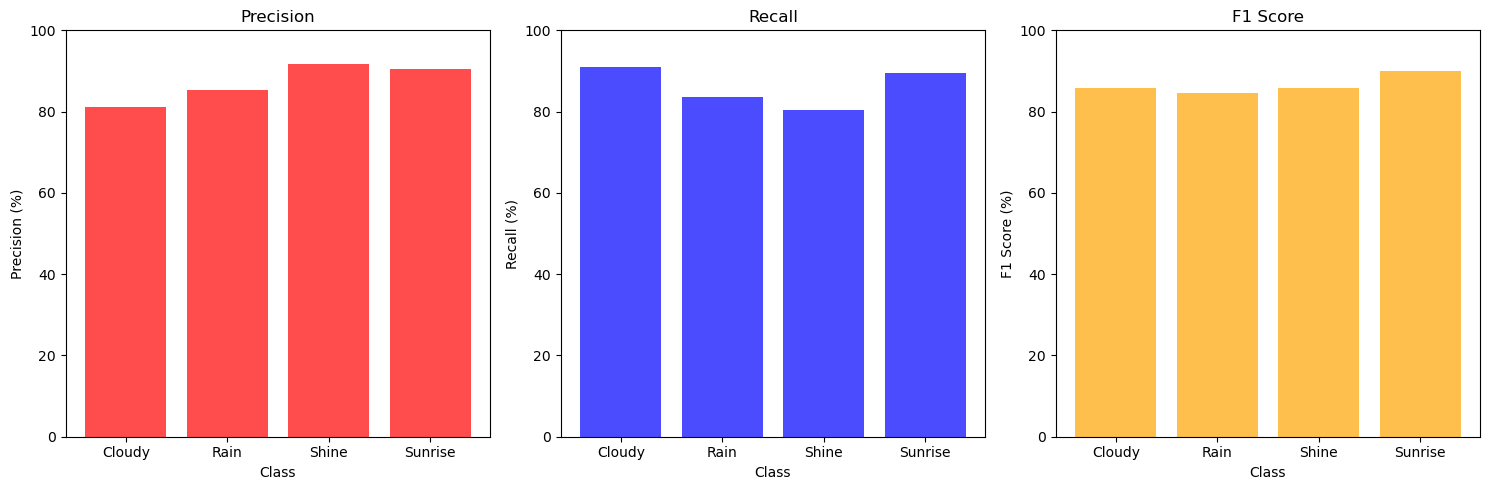

In [7]:
train_folder = 'dataset/train'
test_folder = 'dataset/val'


def extract_lbp_features(image_path, desired_length=1000):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


    if image is not None:
        radius = 3
        n_points = 8 * radius
        lbp_features = feature.local_binary_pattern(image, n_points, radius, method='uniform')


        flattened_lbp = lbp_features.ravel()

        if len(flattened_lbp) < desired_length:
            padded_lbp = np.pad(flattened_lbp, (0, desired_length - len(flattened_lbp)))
            return padded_lbp
        elif len(flattened_lbp) > desired_length:
            truncated_lbp = flattened_lbp[:desired_length]
            return truncated_lbp
        else:
            return flattened_lbp
    else:
        return None

# Function to find the most similar image in the dataset
def find_similar_image(input_features, dataset_features, dataset_labels):
    distances = np.linalg.norm(dataset_features - input_features, axis=1)
    most_similar_index = np.argmin(distances)
    return dataset_labels[most_similar_index]

X_train = []
y_train = []

desired_length = 1000

for class_label in os.listdir(train_folder):
    class_folder = os.path.join(train_folder, class_label)
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)

        # Extract LBP features and skip None values (error loading image)
        lbp_features = extract_lbp_features(image_path, desired_length)
        if lbp_features is not None:
            X_train.append(lbp_features)
            y_train.append(class_label)

X_train = np.array(X_train)
y_train = np.array(y_train)

classifier = SVC(kernel='linear', C=1.0, random_state=42)
classifier.fit(X_train, y_train)

# Extract LBP features from the testing dataset
X_test = []
y_test = []

for class_label in os.listdir(test_folder):
    class_folder = os.path.join(test_folder, class_label)
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)

        lbp_features = extract_lbp_features(image_path, desired_length)
        if lbp_features is not None:
            X_test.append(lbp_features)
            y_test.append(class_label)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_pred = classifier.predict(X_test)

#Calculate precision, recall, and F1 score for each class
classes = np.unique(y_test)

precision_scores = []
recall_scores = []
f1_scores = []

for class_label in classes:
    precision = precision_score(y_test == class_label, y_pred == class_label) * 100
    recall = recall_score(y_test == class_label, y_pred == class_label) * 100
    f1 = f1_score(y_test == class_label, y_pred == class_label) * 100

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"\nClass: {class_label}")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

overall_precision = precision_score(y_test, y_pred, average='weighted') * 100
overall_recall = recall_score(y_test, y_pred, average='weighted') * 100
overall_f1 = f1_score(y_test, y_pred, average='weighted') * 100

print("\nOverall Results:")
print(f"Precision: {overall_precision:.2f}%")
print(f"Recall: {overall_recall:.2f}%")
print(f"F1 Score: {overall_f1:.2f}%")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(classes, precision_scores, color='red', alpha=0.7)
ax[0].set_title('Precision')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Precision (%)')
ax[0].set_yticks(np.arange(0, 101, 20))

ax[1].bar(classes, recall_scores, color='blue', alpha=0.7)
ax[1].set_title('Recall')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Recall (%)')
ax[1].set_yticks(np.arange(0, 101, 20))

ax[2].bar(classes, f1_scores, color='orange', alpha=0.7)
ax[2].set_title('F1 Score')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('F1 Score (%)')
ax[2].set_yticks(np.arange(0, 101, 20))

plt.tight_layout()
plt.show()

input_image_path = os.path.abspath('MWD/Multi-class Weather Dataset/Shine/shine103.jpg')
input_features = extract_lbp_features(input_image_path, desired_length)

# # Function to find similar images in the dataset
# def find_similar_images(input_features, dataset_features, dataset_labels, k=5):
#     distances = pairwise_distances([input_features], dataset_features, metric='euclidean')
#     indices = np.argsort(distances)[0][:k]
#     similar_classes = dataset_labels[indices]
#     return similar_classes

# if input_features is not None:
#     similar_classes = find_similar_images(input_features, X_train, y_train, k=5)

#     print(f"\nThe input image is similar to the classes: {similar_classes}")

#     input_image = cv2.imread(input_image_path)

#     plt.figure(figsize=(15, 5))
#     plt.subplot(1, 6, 1)
#     plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
#     plt.title('Input Image')
#     plt.axis('off')

#     for i, similar_class in enumerate(similar_classes):
#         similar_image_path = os.path.join(train_folder, similar_class, os.listdir(os.path.join(train_folder, similar_class))[0])
#         similar_image = cv2.imread(similar_image_path)
#         plt.subplot(1, 6, i + 2)
#         plt.imshow(cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB))
#         plt.title(f'Similar Class: {similar_class}')
#         plt.axis('off')

#     plt.show()
# else:
#     print("Error loading input image.")


The input image is similar to the classes: ['Shine' 'Rain' 'Rain' 'Sunrise' 'Rain']


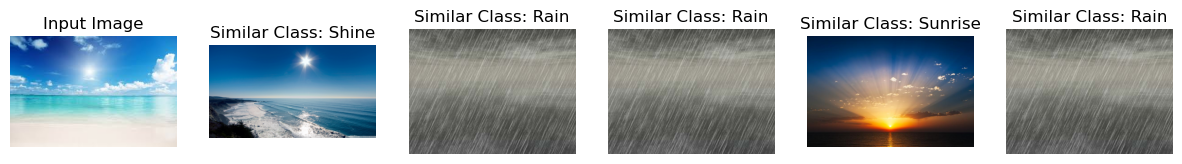

In [8]:
def find_similar_images(input_features, dataset_features, dataset_labels, k=5):
    similarities = cosine_similarity([input_features], dataset_features)
    indices = np.argsort(similarities[0])[-k:][::-1]
    similar_classes = dataset_labels[indices]
    return similar_classes

if input_features is not None:
    similar_classes = find_similar_images(input_features, X_train, y_train, k=5)

    print(f"\nThe input image is similar to the classes: {similar_classes}")

    input_image = cv2.imread(input_image_path)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title('Input Image')
    plt.axis('off')

    for i, similar_class in enumerate(similar_classes):
        similar_image_path = os.path.join(train_folder, similar_class, os.listdir(os.path.join(train_folder, similar_class))[0])
        similar_image = cv2.imread(similar_image_path)
        plt.subplot(1, 6, i + 2)
        plt.imshow(cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Similar Class: {similar_class}')
        plt.axis('off')

    plt.show()
else:
    print("Error loading input image.")
